# 0. Load model and dataset

In [3]:
import torch, skimage
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader

from dataset import HySpecNet11k
from cae1dm import ModifiedConvolutionalAutoencoder1D
from cae3d import ConvolutionalAutoencoder3D
from sscnet import SpectralSignalsCompressorNetwork

def Entropy(inputs):
    _, counts = np.unique(inputs, return_counts=True)
    p = counts/sum(counts)
    entropy = -sum(p*np.log2(p))
    return entropy

device = 'cpu'

In [4]:
res = pd.DataFrame([])
with torch.no_grad():
    for cr in [4, 8]:
        model = ModifiedConvolutionalAutoencoder1D().from_pretrained(f'SOTA/CAE_1DM_{cr}').to(device)
        test_set = HySpecNet11k('/home/deic/zuoxin/Dataset/HySpecNet11k', 'easy', mode="test", bit_shift=0, is_total=False)
        psnr, ssim, Entropy_latent, Entropy_residual = [], [], [], []
        for file in test_set.files:
            img, msb = test_set.load_data(file)
            msb = test_set.prepare_msb(msb).unsqueeze(0).to(device)
            latent = model.compress(msb)
            out = model.decompress(latent)
            latent, out = latent.squeeze().detach().cpu().numpy(), out.squeeze().detach().cpu().numpy()
            out = np.round(out * 10000).astype(np.int16)
            residual = img - out
            max_value = np.max([out.max(), img.max()])
            psnr.append(skimage.metrics.peak_signal_noise_ratio(out, img, data_range=max_value))
            ssim.append(skimage.metrics.structural_similarity(out, img, data_range=max_value))
            Entropy_latent.append(Entropy(latent))
            Entropy_residual.append(Entropy(residual))
        print(latent.shape)
        metrix = dict(PSNR=np.mean(psnr), SSIM=np.mean(ssim), Entropy_latent=np.mean(Entropy_latent), Entropy_residual=np.mean(Entropy_residual))
        res = pd.concat([res, pd.Series(metrix)], axis=1)
res = res.T
res

(51, 128, 128)
(26, 128, 128)


,PSNR,SSIM,Entropy_latent,Entropy_residual
0,48.940532,0.996237,19.610544,5.887086
0,49.195384,0.996447,18.675422,5.825818


In [5]:
res = pd.DataFrame([])
for i in [8, 16, 32, 64]:
    with torch.no_grad():
        model = ConvolutionalAutoencoder3D().from_pretrained(f'SOTA/CAE_3D_{i}').to(device)
        test_set = HySpecNet11k('/home/deic/zuoxin/Dataset/HySpecNet11k', 'easy', mode="test", bit_shift=0, is_total=False)
        psnr, ssim, Entropy_latent, Entropy_residual = [], [], [], []
        for file in test_set.files:
            img, msb = test_set.load_data(file)
            msb = test_set.prepare_msb(msb).unsqueeze(0).to(device)
            latent = model.compress(msb)
            out = model.decompress(latent)
            latent, out = latent.squeeze().detach().cpu().numpy(), out.squeeze().detach().cpu().numpy()
            out = np.round(out * 10000).astype(np.int16)
            residual = img - out
            max_value = np.max([out.max(), img.max()])
            psnr.append(skimage.metrics.peak_signal_noise_ratio(out, img, data_range=max_value))
            ssim.append(skimage.metrics.structural_similarity(out, img, data_range=max_value))
            Entropy_latent.append(Entropy(latent))
            Entropy_residual.append(Entropy(residual))
        print(latent.shape)
        metrix = dict(PSNR=np.mean(psnr), SSIM=np.mean(ssim), Entropy_latent=np.mean(Entropy_latent), Entropy_residual=np.mean(Entropy_residual))
        res = pd.concat([res, pd.Series(metrix)], axis=1)

res = res.T
res

(8, 51, 16, 16)
(16, 51, 16, 16)
(32, 51, 16, 16)
(64, 51, 16, 16)


,PSNR,SSIM,Entropy_latent,Entropy_residual
0,29.774080,0.701279,16.670131,9.098748
0,30.660788,0.736808,17.668308,8.959527
0,30.912238,0.753115,18.664715,8.921971
0,31.234655,0.874882,19.655705,8.754467


In [6]:
res = pd.DataFrame([])
for i in [4, 8, 16, 32]:
    with torch.no_grad():
        model = SpectralSignalsCompressorNetwork().from_pretrained(f'SOTA/SSCNET_{i}').to(device)
        test_set = HySpecNet11k('/home/deic/zuoxin/Dataset/HySpecNet11k', 'easy', mode="test", bit_shift=0, is_total=False)
        psnr, ssim, Entropy_latent, Entropy_residual = [], [], [], []
        for file in test_set.files:
            img, msb = test_set.load_data(file)
            msb = test_set.prepare_msb(msb).unsqueeze(0).to(device)
            latent = model.compress(msb)
            out = model.decompress(latent)
            latent, out = latent.squeeze().detach().cpu().numpy(), out.squeeze().detach().cpu().numpy()
            out = np.round(out * 10000).astype(np.int16)
            residual = img - out
            max_value = np.max([out.max(), img.max()])
            psnr.append(skimage.metrics.peak_signal_noise_ratio(out, img, data_range=max_value))
            ssim.append(skimage.metrics.structural_similarity(out, img, data_range=max_value))
            Entropy_latent.append(Entropy(latent))
            Entropy_residual.append(Entropy(residual))
        print(latent.shape)
        metrix = dict(PSNR=np.mean(psnr), SSIM=np.mean(ssim), Entropy_latent=np.mean(Entropy_latent), Entropy_residual=np.mean(Entropy_residual))
        res = pd.concat([res, pd.Series(metrix)], axis=1)
res = res.T
res

(3232, 16, 16)
(1616, 16, 16)
(808, 16, 16)
(404, 16, 16)


,PSNR,SSIM,Entropy_latent,Entropy_residual
0,31.906037,0.805598,19.646980,8.764809
0,31.653874,0.797025,18.651877,8.805354
0,31.107048,0.781065,17.654591,8.892290
0,30.722654,0.767784,16.656178,8.956616


In [13]:
cae1d =  pd.DataFrame(dict(
    psnr=[48.940532, 49.195384], 
    entropy1=[19.610544, 18.675422], 
    entropy2=[5.887086, 5.825818], 
    cr=[(51*128*128)/3309568, (26*128*128)/3309568]))

cae3d =  pd.DataFrame(dict(
    psnr=[29.774080, 30.660788, 30.912238, 31.234655], 
    entropy1=[16.670131, 17.668308, 18.664715, 19.655705], 
    entropy2=[9.098748, 8.959527, 8.921971, 8.754467],
    cr=[(8*51*16*16)/3309568, (16*51*16*16)/3309568, (32*51*16*16)/3309568, (64*51*16*16)/3309568]))
sscnet = pd.DataFrame(dict(
    psnr=[31.906037, 31.653874, 31.107048, 30.722654], 
    entropy1=[19.646980, 18.651877, 17.654591, 16.656178], 
    entropy2=[8.764809, 8.805354, 8.892290, 8.956616],
    cr=[(3232*16*16)/3309568, (1616*16*16)/3309568, (808*16*16)/3309568, (404*16*16)/3309568]))
linerwkv = pd.DataFrame(dict(
    psnr=[69.687609, 59.031683, 55.056647, 52.989961, 51.126869], 
    entropy1=[3.797908, 2.136309, 1.443879, 1.042736, 0.685562], 
    cr=[1, 1, 1, 1, 1]))

sgst = pd.DataFrame(dict(
    psnr=[45.280275, 44.883903, 43.726225, 40.922772, 38.579958], 
    entropy1=[2.171043, 1.488202, 0.955253, 0.557075, 0.340648], 
    entropy2=[6.371312, 6.376611, 6.405887, 6.475108, 6.529373],
    cr=[1, 1, 1, 1, 1]))

cae1d['entropy_avg'] = cae1d['entropy1'] * cae1d['cr']
cae3d['entropy_avg'] = cae3d['entropy1'] * cae3d['cr']
sscnet['entropy_avg'] = sscnet['entropy1'] * sscnet['cr']
linerwkv['entropy_avg'] = linerwkv['entropy1'] * linerwkv['cr']
sgst['entropy_avg'] = sgst['entropy1'] * sgst['cr']

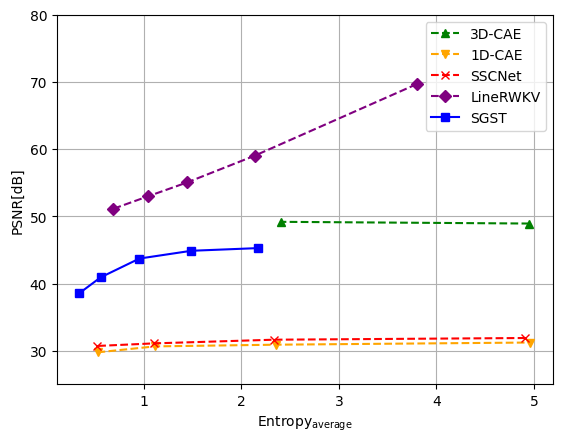

In [8]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams.update({
    'font.size': 14,                
    'axes.titlesize': 16,           
    'axes.labelsize': 14,           
    'xtick.labelsize': 12,          
    'ytick.labelsize': 12,          
    'legend.fontsize': 12,          
    'figure.titlesize': 18          
})

plt.plot(cae1d['entropy_avg'], cae1d['psnr'], marker='^', linestyle='--', color='g', label='1D-CAE')
plt.plot(cae3d['entropy_avg'], cae3d['psnr'], marker='v', linestyle='--', color='orange', label='3D-CAE')
plt.plot(sscnet['entropy_avg'], sscnet['psnr'], marker='x', linestyle='--', color='r', label='SSCNet')
plt.plot(linerwkv['entropy_avg'], linerwkv['psnr'], marker='D', linestyle='--', color='purple', label='LineRWKV')
plt.plot(sgst['entropy_avg'], sgst['psnr'], marker='s', linestyle='-', color='b', label='SGST')
plt.ylabel('PSNR[dB]')
plt.xlabel('H$_{avg}$')
plt.grid()
plt.ylim([25, 72])
plt.legend()
plt.savefig('PSNR.png', dpi=600)

In [14]:
cae1d['entropy_avg']  + cae1d['entropy2']

0    10.838263
1     8.229585
dtype: float64

In [15]:
cae3d['entropy_avg'] + cae3d['entropy2']

0     9.624847
1    10.074730
2    11.278160
3    13.717046
dtype: float64

In [16]:
sscnet['entropy_avg'] + sscnet['entropy2']

0    13.676554
1    11.136839
2     9.995702
3     9.477122
dtype: float64

In [17]:
sgst['entropy_avg'] + sgst['entropy2']

0    8.542355
1    7.864813
2    7.361140
3    7.032183
4    6.870021
dtype: float64